In [1]:
import numpy as np
import pandas as pd
import pygmt
import os
import time
from datetime import datetime
from pyproj import Geod
from multiprocessing import Pool, cpu_count

# ------------------------ function use in calculation ---------------------------------
def dist2Dsimple(minlong,maxlong,minlat,maxlat):
    '''
    assumed the area is plain, and 1 degree = 111320 m
    '''
    deg_to_m = 111320
    # convert to numeric 
    minlong = np.float64(minlong)
    maxlong = np.float64(maxlong)
    minlat = np.float64(minlat)
    maxlat = np.float64(maxlat)
    #
    dist = np.sqrt(((maxlong - minlong )**2) + ((maxlat - minlat ) **2))* deg_to_m #
    return dist
def dist2d(long1, lat1,long2, lat2):
    from pyproj import Geod
    '''
    calculate the distance of 2 points
    '''
    # Define geodetic system (WGS84)
    geod = Geod(ellps='WGS84')
    _, _, dist = geod.inv(long1, lat1,long2, lat2)
    
    return dist
### ------------------- ###
def area_ha(minlong,maxlong,minlat,maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon
    # Define a list of (longitude, latitude) coordinates that form the boundary of the study area
    coords = [(minlong, minlat), (minlong, maxlat), (maxlong, maxlat), (maxlong, minlat)] 
    # Create a Polygon from the coordinates
    polygon = Polygon(coords)
    # Create a GeoDataFrame with WGS84 CRS (EPSG:3405)
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:6405", geometry=[polygon])
    # Reproject to a UTM projection for area calculation (adjust EPSG based on your location)
    gdf = gdf.to_crs(epsg=3405)  # UTM zone 48N for Vietnam
    # Calculate the area in square meters
    area_sq_meters = gdf.geometry.area[0]
    # Convert square meters to hectares (1 hectare = 10,000 square meters)
    area_hectares = area_sq_meters #/ 10000
    return area_hectares
### ------------------- ###
def area_ha_plain(minlong,minlat,maxlong,maxlat):
    '''
    assumed the area is plain, and 1 degree = 111320 m
    '''
    deg_to_m = 111320
    aream = ((maxlong - minlong ) * deg_to_m) * ((maxlat - minlat ) * deg_to_m) #
    area =  aream/10000 # 1 ha = 10000 meters
    return area
    
### ------------------- ###
def cal_body_cross_section(DBH):
    import numpy as np
    '''
    Calculate the speccy's cross-section diameter follow Curtis & Macintosh 1951
    '''
    DBH = np.float64(DBH)
    #
    G = (3.142 * (DHB**2))/40000
    return G
### ------------------- ###
def density(NoS,area):
    '''
    Calculate the density based on the data frame data (number of speccy over all number of species)
    '''
    #
    NoS = np.int(NoS);
    area = np.float64(area);
    #
    dens = NoS/area;
    #
    return dens
### ------------------- ###
def cal_sp_super():
    '''
    Calculate the species superiority index based on the density and body crosssection
    '''
    return IVI
# -----------------------------------------------------------------------------------------    
def process_pair(args):
    '''
    parallel process the data of the dataframe
    '''
    i, sname, datanow = args
    row_i = datanow.loc[i]
    result = []

    for j in range(len(datanow)):
        if i == j:
            continue

        row_j = datanow.loc[j]

        dist_now = dist2d(row_i['Longitude'], row_i['Latitude'],
                          row_j['Longitude'], row_j['Latitude'])

        result.append([
            row_i['sname'], row_i['Code'], row_i['Longitude'], row_i['Latitude'],
            row_i['d2x'], row_i['d2y'], row_i['C(cm)'], row_i['DBH(cm)'], row_i['S(m2)'], row_i['Code'],
            row_j['sname'], row_j['Code'], row_j['Longitude'], row_j['Latitude'],
            row_j['d2x'], row_j['d2y'], row_j['C(cm)'], row_j['DBH(cm)'], row_j['S(m2)'], row_j['Code'],
            dist_now
        ])

    return result
# ---------------------------------------------------------------------------------------

if __name__ == "__main__":
    # Start timing
    t0 = time.time()
    start_time_str = datetime.now().strftime("Start time: %a %b %d %H:%M:%S %Y")
    print(start_time_str)
    
    pwd = os.getcwd()
    # output directory already created in step 0
    # read the data and kip 2 rows due to format error
    data = pd.read_csv(os.path.join(pwd,"output","00_intitial_data.txt"), sep=',',
                       # names=["index","jk1","name","lat","long","code"],
                       header=0,
                      )
    data
    # # # Now calculate the area for study area based on the species coordinantes
    cal_min_x=data['Longitude'].min()
    cal_max_x=data['Longitude'].max()
    cal_min_y=data['Latitude'].min()
    cal_max_y=data['Latitude'].max()
    
    # S = area_ha_plain(cal_min_x,cal_max_x,cal_min_y,cal_max_y)
    # # --- > End section Preprocess the dataframe < --- #
    # pre-condition for the data frame
    source=[];  source_code=[]; site_code=[]; source_long=[]; source_lat=[]; source2x=[]; source2y=[];
    soure_C=[]; soure_DBH=[]; soure_S=[]; soure_scode=[];
    site=[]; site_long=[]; site_lat=[]; site2x=[]; site2y=[]; site_C=[]; site_DBH=[]; site_S=[]; site_scode=[];
    distance=[];
    # #
    datanow = data.copy();
    # datanow['sname'] = ['S' + str(i).zfill(4) for i in datanow.index]
    if 'sname' not in datanow.columns:
        datanow['sname'] = ['S' + str(i).zfill(4) for i in datanow.index]

    datanow.reset_index(drop=True, inplace=True)
    num_cpus = min(40, cpu_count()) # set minimum CPU run as 40
    print("Starting parallel processing with {} cores...".format(num_cpus))

    # Prepare arguments
    args = [(i, datanow.loc[i, 'sname'], datanow) for i in range(len(datanow))]

    with Pool(processes=cpu_count()) as pool:
        all_results = pool.map(process_pair, args)

    # Flatten list of lists
    flat_results = [item for sublist in all_results for item in sublist]

    # Create DataFrame
    columns = ['source', 'source_code', 'source_long', 'source_lat', 'source2x', 'source2y',
               'source_C', 'source_DBH', 'source_S', 'source_spiccies_code',
               'site', 'site_code', 'site_long', 'site_lat', 'site2x', 'site2y',
               'site_C', 'site_DBH', 'site_S', 'site_spiccies_code', 'Dist']

    dataout = pd.DataFrame(flat_results, columns=columns)
    print("Write the dataframe to file!")  
    dataout.to_csv(os.path.join(pwd,"output","01_all_distances.txt"),index=False,sep=',',header=True,encoding='utf-8')
    print(' >>>> Export the output file: {}'.format(os.path.join(pwd,"output","01_all_distances.txt")))
    # End timing
    t1 = time.time()
    end_time_str = datetime.now().strftime("End time: %a %b %d %H:%M:%S %Y")  
    total_time = t1 - t0
    print(end_time_str)
    
    print("Total process time: {:.2f} seconds".format(total_time))
    print("Process done!")        

Start time: Mon Jul 28 11:21:51 2025
Starting parallel processing with 40 cores...
Write the dataframe to file!
End time: Mon Jul 28 11:22:06 2025
Total process time: 15.04 seconds
Process done!


Start time: Mon Jul 28 11:22:11 2025


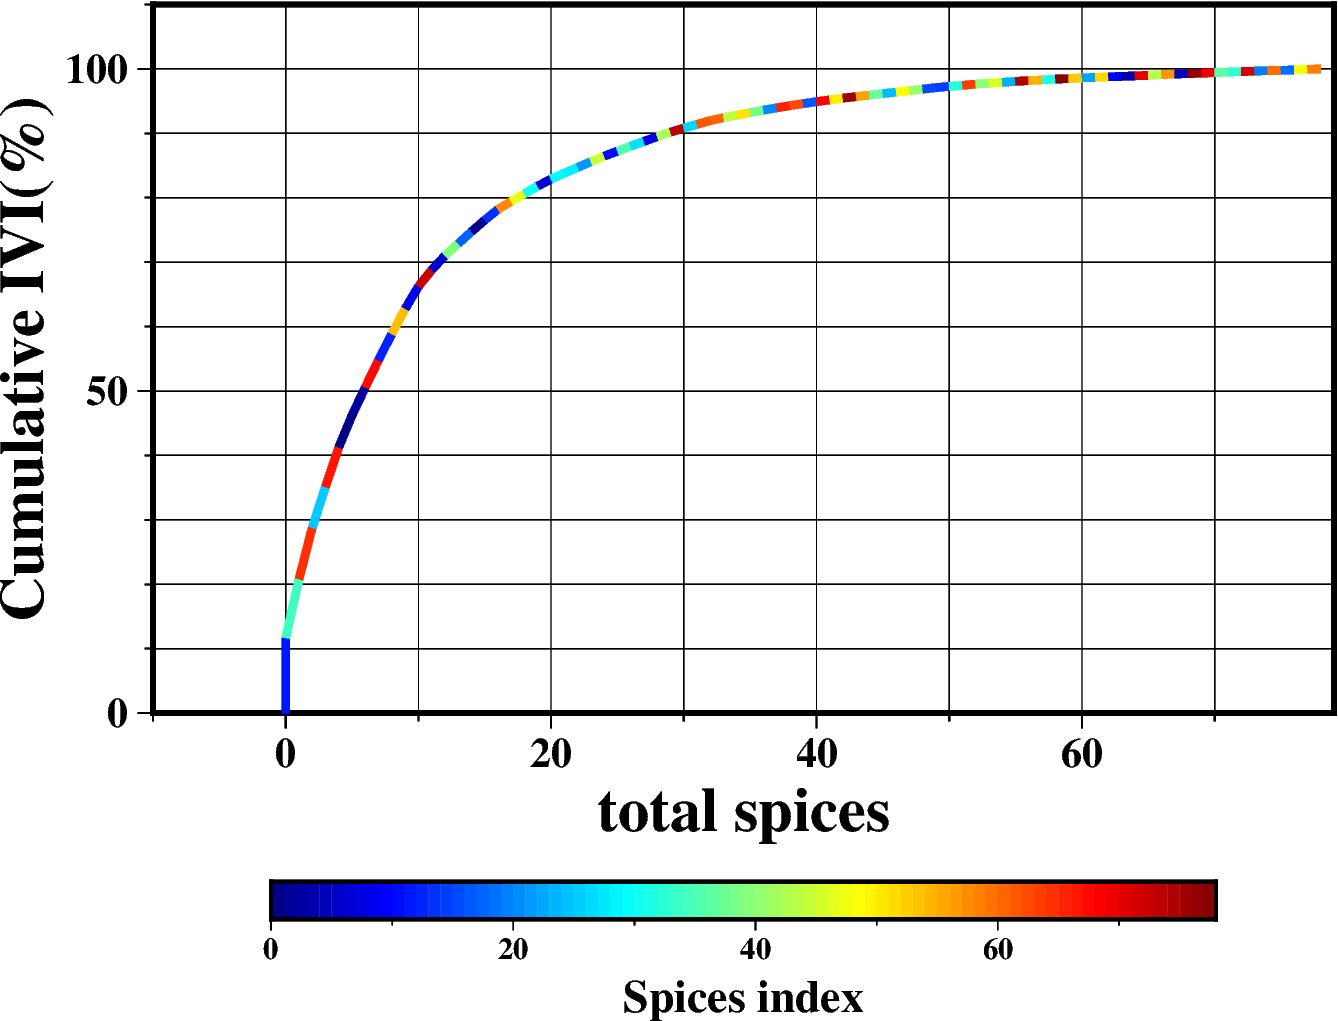

End time: Mon Jul 28 11:22:15 2025
Total process time: 4.11 seconds
Process done!


In [2]:
import numpy as np
import pandas as pd
import pygmt
import os
from multiprocessing import Pool, cpu_count
import time
import sys
from datetime import datetime
# ====================================================================================================================================
'''
Determine the species density, relative frequency (G), and Importance Value Index (IVI) for each type of plant recorded in the dataset.
Output: The cumulate IVI figure and output file: 
'''
# ====================================================================================================================================
def area_ha(minlong, maxlong, minlat, maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon

    # Create the polygon with 4 input points
    coords = [(minlong, minlat), (minlong, maxlat), 
              (maxlong, maxlat), (maxlong, minlat)]
    polygon = Polygon(coords)

    # create GeoDataFrame with  WGS84 coordinates system
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

    # swich to UTM zone 48N (Vietnam) to calculate the area
    gdf = gdf.to_crs(epsg=3405)  # EPSG:3405 is VN-2000 / UTM zone 48N

    # Area as squared-metter
    area_sq_meters = gdf.geometry.area.iloc[0]

    # Convert to ha (1 ha = 10,000 m2)
    area_hectares = area_sq_meters / 10000

    return area_hectares
    
def area(minlong, maxlong, minlat, maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon

    # Create the polygon with 4 input points
    coords = [(minlong, minlat), (minlong, maxlat), 
              (maxlong, maxlat), (maxlong, minlat)]
    polygon = Polygon(coords)

    # create GeoDataFrame with  WGS84 coordinates system
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

    # swich to UTM zone 48N (Vietnam) to calculate the area
    gdf = gdf.to_crs(epsg=3405)  # EPSG:3405 là VN-2000 / UTM zone 48N

    # Area as squared-metter
    area_sq_meters = gdf.geometry.area.iloc[0]

    # Convert to ha (1 ha = 10,000 m2)
    area = area_sq_meters

    return area
# ====================================================================================================================================
pwd = os.getcwd()
#
infile = os.path.join(pwd,"output","01_all_distances.txt")
#
if not os.path.isfile(infile):
    raise FileNotFoundError("Required file not found: {}".format(infile))
data = pd.read_csv(infile,sep=",",header=0)
# Calculate the S and total density
xmin = data['source_long'].min();
xmax = data['source_long'].max();
ymin = data['source_lat'].min();
ymax = data['source_lat'].max();
# the area of the quarant
S = area_ha(xmin,xmax,ymin,ymax)
# the area of the quarant
Sm = area(xmin,xmax,ymin,ymax)
# speicy density
denall = len(data['source'].unique())/S; # equal to 100% density
# total DBH
DBH_all = (data.groupby('source', as_index=False)['source_DBH'].first())['source_DBH'].sum();
# stem cross-sectional area (G)
data['G'] = (np.pi * data['source_DBH']*data['source_DBH'])/200**2
# Total G
G_all = (data.groupby('source', as_index=False)['G'].first())['G'].sum();
# pre-condition the data
sourcecode = [];
N = [];
rel_N = [];
rel_G = [];
rel_IVI = [];
source_codes = [];
sourcelong = [];
sourcelat = [];
Area = [];

# Start timing
t0 = time.time()
start_time_str = datetime.now().strftime("Start time: %a %b %d %H:%M:%S %Y")
print(start_time_str)

for i,scode in enumerate(data['source_code'].unique()):
# for i,scode in enumerate(['A1']):
    datanow=data[data['source_code'] == scode]; datanow.reset_index(drop=True,inplace=True)
    Nnow = len(datanow['source'].unique())/S # current density
    rel_Nnow = (Nnow/denall)*100 # relative density now
    rel_Gnow = ((datanow.groupby('source', as_index=False)['G'].first())['G'].sum()/G_all)*100 # relative G
    rel_IVInow = (rel_Nnow + rel_Gnow)/2
    # print(i,scode)
    # print(Nnow,rel_Nnow,rel_Gnow,rel_IVInow)
    # append the data
    sourcecode = np.append(sourcecode,scode);
    N = np.append(N,Nnow);
    Area = np.append(Area,Sm);
    rel_N = np.append(rel_N,rel_Nnow);
    rel_G = np.append(rel_G,rel_Gnow);
    rel_IVI = np.append(rel_IVI,rel_IVInow);
    sourcelong = np.append(sourcelong,datanow['source_long'][i]);
    sourcelat = np.append(sourcelat,datanow['source_lat'][i]);
dataIVI = pd.DataFrame({
    'sourcecode' : sourcecode,
    'sourcelong' : sourcelong,
    'sourcelat' : sourcelat,
    'Area' : Area,
    'N' : N,
    'N%' : rel_N,
    'G%' : rel_G,
    'IVI%' : rel_IVI
})
dataIVI.to_csv(os.path.join(pwd,"output","01_all_IVI.txt"),index=False,sep=',',header=True,encoding='utf-8')
print("Export the bridging file: {}".format(os.path.join(pwd,"output","01_all_IVI.txt")))
dataIVI_sorted = dataIVI.sort_values(by='IVI%', ascending=False)
dataIVI_sorted['IVIcu'] = dataIVI_sorted['IVI%'].cumsum()
dataIVI_sorted['idx']=dataIVI_sorted.index
dataIVI_sorted.reset_index(drop=True,inplace=True)
dataIVI_sorted['index'] = dataIVI_sorted.index  # explicitly add it as a column
dataIVI_sorted.to_csv(os.path.join(pwd,"output","01_all_IVI_sorted.txt"),index=False,sep=',',header=True,encoding='utf-8')
print("Export the output file: {}".format(os.path.join(pwd,"output","01_all_IVI_sorted.txt")))

# Plot the figure
fig = pygmt.Figure()
# Config the figure 
pygmt.config(FONT_LABEL="15p,Times-Bold,black")
pygmt.config(FONT_TITLE="15p,Times-Bold,black")
pygmt.config(FONT_ANNOT_PRIMARY="10p,Times-Bold,black")
pygmt.config(FONT_ANNOT_SECONDARY="10p,Times-Roman,black")
pygmt.config(MAP_FRAME_TYPE="fancy")
pygmt.config(FORMAT_GEO_MAP="ddd.xxF")

# pygmt.makecpt(cmap="viridis", series=[dataIVI_sorted.idx.min(), dataIVI_sorted.idx.max()])
pygmt.makecpt(cmap="jet", series=[0, int(dataIVI_sorted.idx.max()), 1], color_model="+c0-{}".format(int(dataIVI_sorted.idx.max())))
# Set region and projection
fig.basemap(
    region=[-10, len(dataIVI_sorted), 0, 110],
    projection="X10c/6c",
    frame=["yafg10+lCumulative IVI(%)", "xafg10+ltotal spices"]
)

plot_data = dataIVI_sorted[['index', 'IVIcu', 'idx']]  # x, y, intensity (z)
# Fill under the curve
for i,z in enumerate(dataIVI_sorted['idx']):
    if i == 0:
        x = [0, dataIVI_sorted['index'][0]]
        y = [0, dataIVI_sorted['IVIcu'][0]]
    else:
        x=dataIVI_sorted['index'][i-1:i+1];
        y=dataIVI_sorted['IVIcu'][i-1:i+1];
    # print(x,y,z)
    fig.plot(x=x, y=y, cmap=True, zvalue=z, pen="2p,+z,-")
#
pygmt.makecpt(cmap="jet", series=[0, int(dataIVI_sorted.idx.max()), 1])
fig.colorbar(frame='af+l"Spices index"')
fig.savefig(os.path.join(pwd,"figures","01.Cumulative_IVI.png"),crop=True, dpi=500, transparent=False)
print("Export the figure: {}".fornat(os.path.join(pwd,"figures","01.Cumulative_IVI.png")))
fig.show()
# End timing
t1 = time.time()
end_time_str = datetime.now().strftime("End time: %a %b %d %H:%M:%S %Y")  
total_time = t1 - t0
print(end_time_str)

print("Total process time: {:.2f} seconds".format(total_time))
print("Process done!") 